<a href="https://colab.research.google.com/github/A00447694/Vector-Workshop/blob/main/Chauhan-assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

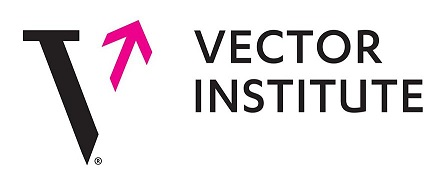
### **Welcome to the Bias in AI Course!**
This program is offered by Vector Institute in partnership with the CRA.

Instructor: Sayyed Nezhadi
| Assignment Developer: Rishav Agarwal
| Course Tutors: Reem Al-Saidi and Rishav Agarwal
| Course Director: Melissa Valdez

### ***Never stop learning!***

### Assginment 2: Understanding Text Recognition From Images

This assignment is split into two parts. First, we will learn how to use a simple text recognition model and in part two we will learn how to create a text detection model. You will understand how text information is extracted from images, and how object detection models are trained. Finally, you will be able to see real time predictions from the the same. 

The text recognition is based on [Google Tesseract](https://tesseract-ocr.github.io/tessdoc/Home.html).

Much of the data localization approach is based on the paper [DiT: Self-supervised Pre-training for Document Image Transformer](https://arxiv.org/abs/2203.02378)  and the code is adopted from this [git repo](https://github.com/microsoft/unilm/tree/master/dit).


**Submission Note:** Please ensure you save your notebook to PDF and submit it along with your.ipynb notebooks. Notebooks on their own will not be graded.

**Grade:** This assignment is graded out of 105 (with possible + 15 bonus) and will contribute to 15% of your grade. Please see D2L for the grading breakdown.

#### Changing Runtime

Change the runtime to use a GPU accelerator. You can use a free GPU on colab by selecting:

**Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

#### Installing Libraries

We will first install the relevant libraries. You may need to restart the instance (**Runtime** → **Restart Runtime**). Note that this needs to be done once.



In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract transformers timm
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!git clone https://github.com/microsoft/unilm.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 8s (616 kB/s)
debconf: unable to initial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-t2c9pi4e
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-t2c9pi4e
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 151 kB 41.6 MB/s 
     |████████████████████████████████| 1.4 MB 65.1 MB/s 
     |████████████████████████████████| 248 kB 69.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 843 kB 51.6 MB/s 
     |████████████████████████████████| 117 kB 71.9 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux

Cloning into 'unilm'...
remote: Enumerating objects: 6432, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6432 (delta 0), reused 0 (delta 0), pack-reused 6429
Receiving objects: 100% (6432/6432), 10.85 MiB | 21.49 MiB/s, done.
Resolving deltas: 100% (2890/2890), done.


### Part 1: Text Recognition using OCR [50]

#### Helper Functions

Here we will define some helper functions.


In [2]:
import cv2
import pytesseract 
from matplotlib import pyplot as plt
import urllib.request as request
import numpy as np

def draw_text_on_image(img, results, min_conf = 0):
  '''
  '''
  im_w, im_h = img.shape[:2]
  text_img = np.ones((im_w, 2*im_h, 3))
  for i in range(len(results["text"])):    
      # Extract the bounding box coordinates

      x1, y1, x2, y2 = results["bbox"][i]
      
      # Extract the text and confidence of the text localization
      text = results["text"][i]
      conf = float(results["conf"][i])
      
      # filter out weak confidence text localizations
      if conf > min_conf and len(text) > 0:
          text =  "".join(text).strip()
          cv2.rectangle(img,
                        (x1, y1),
                        (x2, y2),
                        (0, 0, 255), 1)
          cv2.putText(text_img,
                      text,
                      (x1, y1),
                      cv2.FONT_HERSHEY_SIMPLEX,
                      .5, (0, 255, 255), 1)
  text_img[:, im_h:, : ] = img
  return text_img.astype(np.uint8)

def format_tesseract_output(result):
  '''
  '''
  result["bbox"] = []
  for i in range(len(result["text"])): 
      x = result["left"][i]
      y = result["top"][i]
      w = result["width"][i]
      h = result["height"][i]
      result["bbox"].append([x,y,x+w, y+h])
      result["conf"][i] = int(result["conf"][i])/100
  return result

def download_image(img_path):
  '''
  Given image path, downloads and returns the image in RGB format
  '''
  req = request.urlopen(img_path)
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  full_img = cv2.imdecode(arr, -1) # 'Load it as it is'
  full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
  return full_img

def ocr_patch(full_img, crop = None, scale = 1, min_conf = .8, viz = False):
  '''
  Function to return 
  '''

  # Add cropping logic here
  if crop is not None:  
    # Code Here
    pass
  else:
    img = full_img 
  #print(x1, y1, x2, y2)
  width, height  = img.shape[:2]
  print(width, height)
  img_scaled = cv2.resize(img, dsize = (int(width*scale), int(height*scale)))
  results = pytesseract.image_to_data(img_scaled, output_type=pytesseract.Output.DICT)
  results  = format_tesseract_output(results)
  if viz:
    plt.figure(figsize = (20, 20))
    plt.imshow(draw_text_on_image(img_scaled, results, min_conf = min_conf))
    plt.show()

  return results

Let us start with loading an image of an unfilled CRA form. 




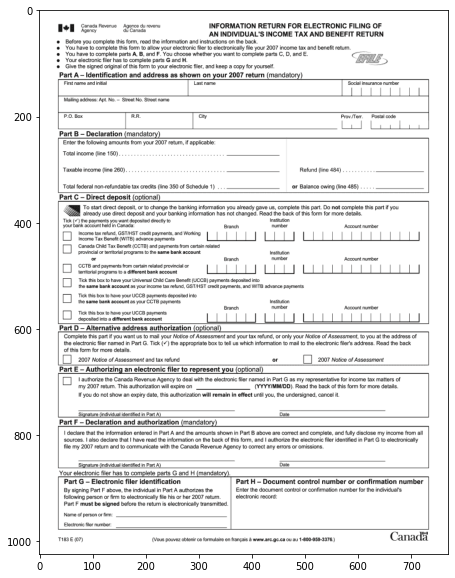

In [3]:
img_path = 'https://www.signnow.com/preview/14/715/14715322/large.png'
img = download_image(img_path)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

##### **Q1.a** Try to run the `ocr_patch` function defined above on entire test image. You may need to set `crop = None` and `viz = True` to vizualize the image. What peculiar features do you see in the image? [5]
##### **Q1.b** Try scaling the image using the `scale` parameter. Does scaling help? Why do you think it does/doesn't? [10]

Ans 1.a)

1024 770


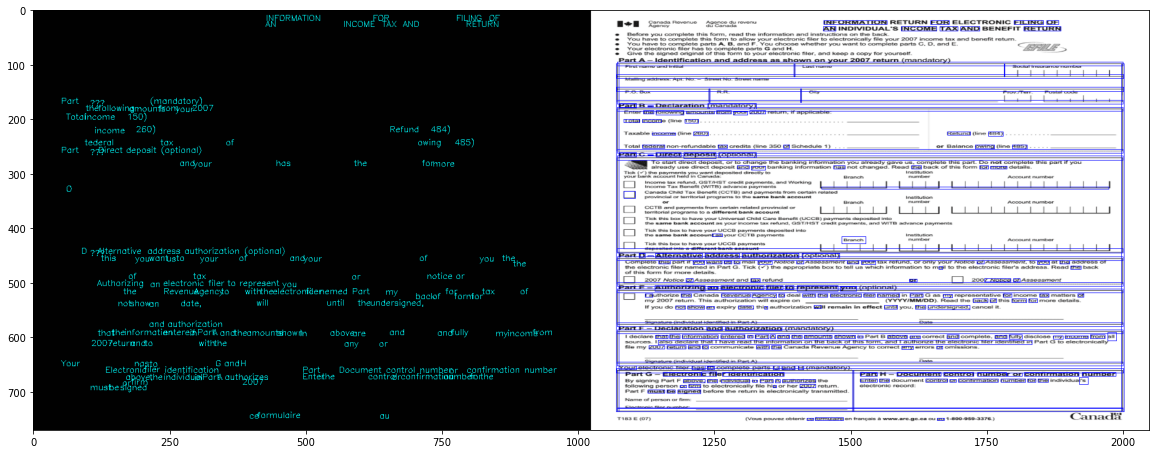

<Figure size 1440x1440 with 0 Axes>

In [7]:
# Code here (1 line)
result = ocr_patch(img, crop = None, viz = True)
plt.figure(figsize = (20,20))
plt.show()

The result is that the text is localized and are surrounded by  bounding boxes. The image is scaled and some of the localized text is recognized in the image on the left. 

Ans 1.b)

1024 770


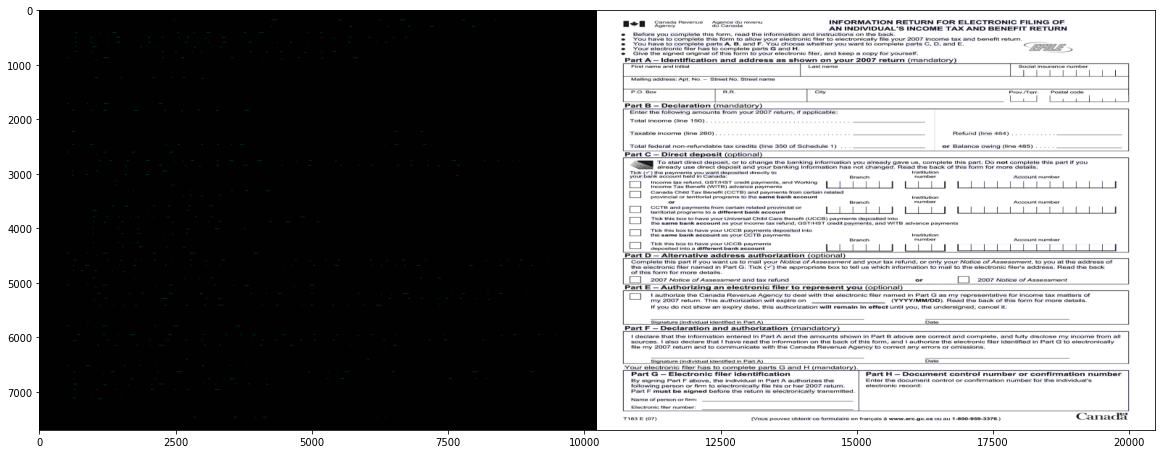

<Figure size 1440x1440 with 0 Axes>

In [15]:
result = ocr_patch(img, crop = None, scale = 10, viz = True)
plt.figure(figsize = (20,20))
plt.show()

1024 770


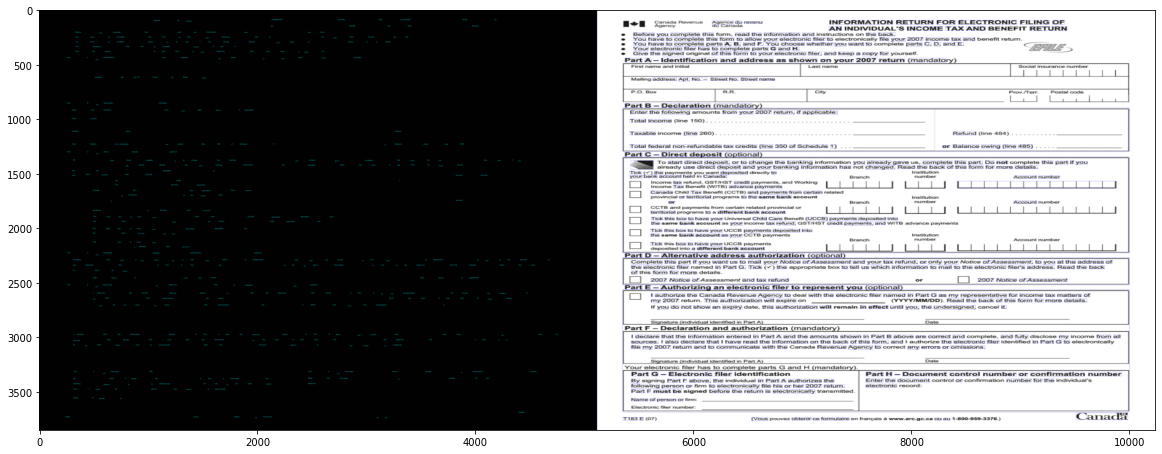

<Figure size 3600x3600 with 0 Axes>

In [17]:
# Code here (2+ lines)
result = ocr_patch(img, crop = None, scale = 5, viz = True)
plt.figure(figsize = (50,50))
plt.show()

1024 770


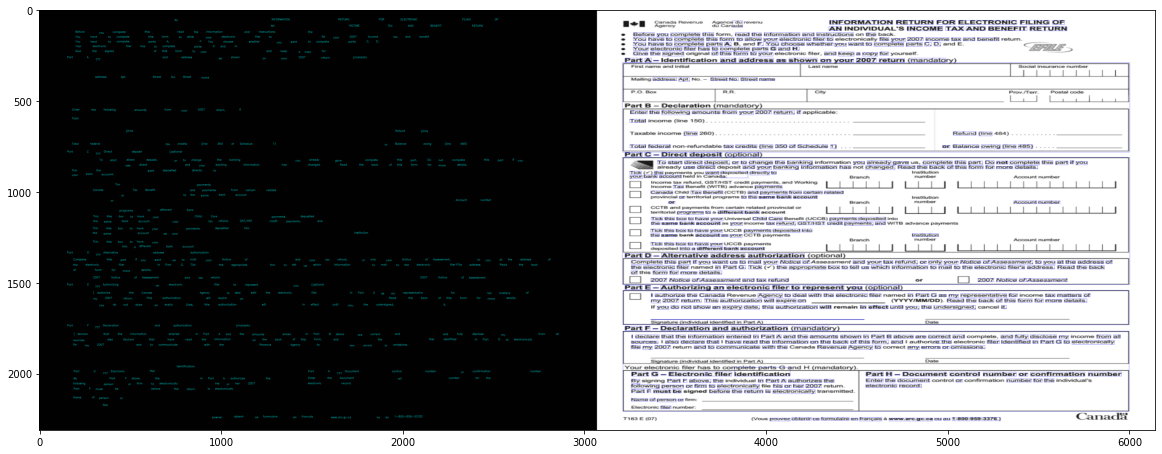

<Figure size 1440x1440 with 0 Axes>

In [9]:
result = ocr_patch(img, crop = None, scale = 3, viz = True)
plt.figure(figsize = (20,20))
plt.show()

1024 770


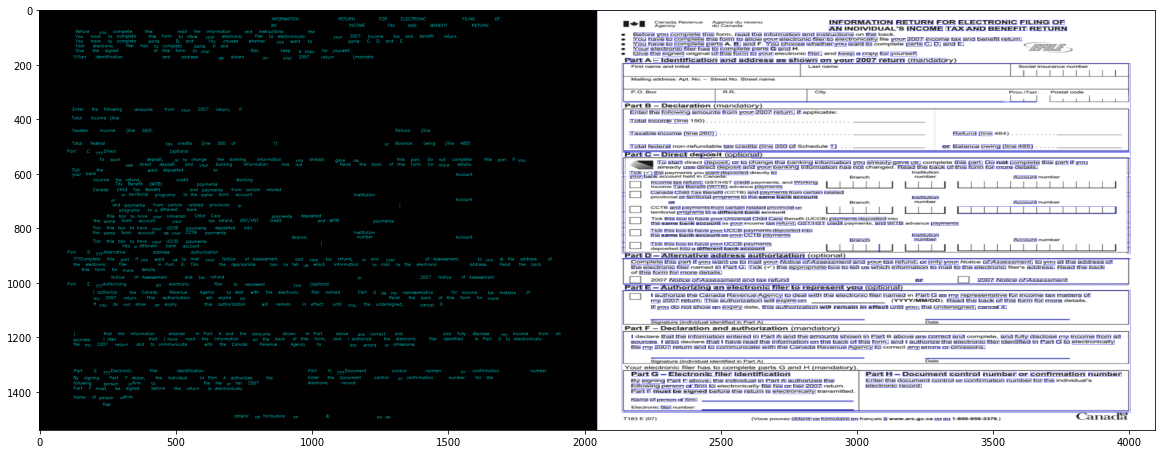

<Figure size 1440x1440 with 0 Axes>

In [11]:
result = ocr_patch(img, crop = None, scale = 2, viz = True)
plt.figure(figsize = (20,20))
plt.show()

1024 770


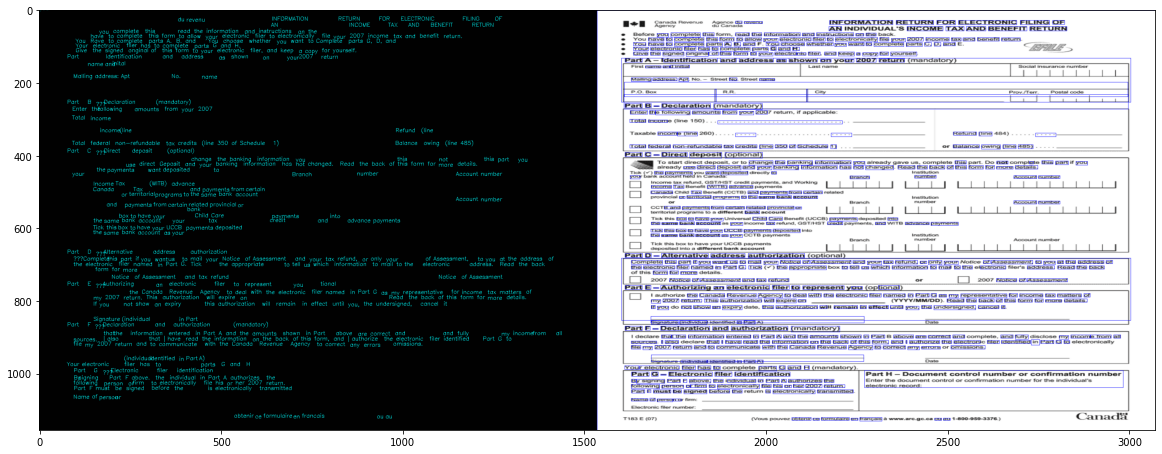

<Figure size 1440x1440 with 0 Axes>

In [12]:
result = ocr_patch(img, crop = None, scale = 1.5, viz = True)
plt.figure(figsize = (20,20))
plt.show()

1024 770


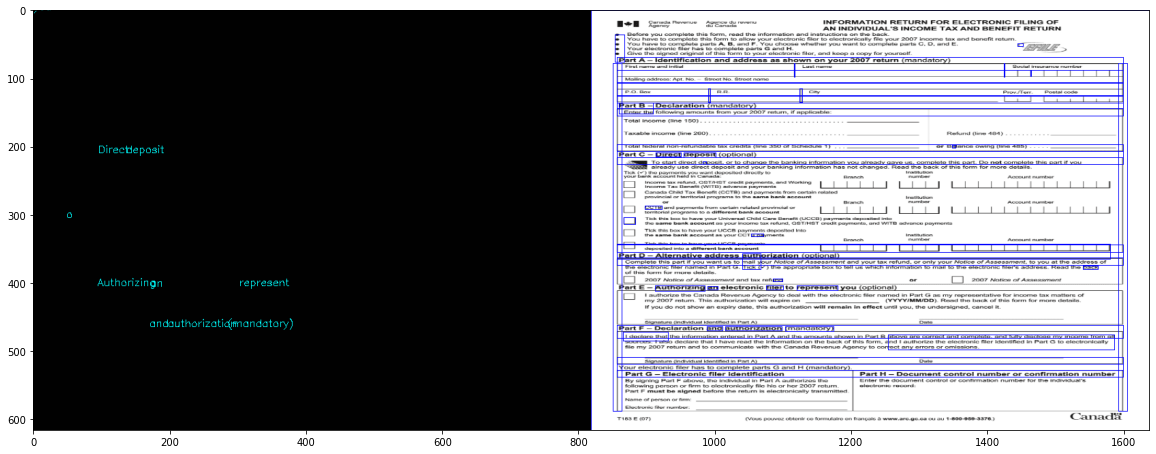

<Figure size 1440x1440 with 0 Axes>

In [16]:
result = ocr_patch(img, crop = None, scale = 0.80, viz = True)
plt.figure(figsize = (20,20))
plt.show()

The higher the value of `scale` parameter, the greater the detected text (including individual words) can be despite being unclear. We observed that a `scale` value of 2 detected more text than a value of 1 as lower values missed to capture many individual words which were detected otherwise with the higher values. Hence, an optimal value of `scale` does help with the text detection.



##### **Q2** Try to analyze the text from the **Q1.a** as follows: 

1.   Are there non-dictionary words? 
2.   What kind of words are low-confidence and which are high?
3.   What is the overall confidence trend with scale? [15]

*Hint:* You can use [`pyenchant`](https://pyenchant.github.io/pyenchant/) for this. Import and dictionary selection are completed below. You can create two arrays, one to store whether or not the word is a dictionary word, and one for each word's confidence score. Then use a for loop to fill those arrays. Finally, use matplotlib to create a scatterplot of the binary dictionary word vs. confidence score. Discuss your findings.


*Bonus:* Try some advanced analysis, and see if there are interesting patterns. This part is open ended for your own curiosity. 

Ans 2.1)

In [18]:
!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/

In [ ]:
import enchant
import pandas as pd

In [74]:
def analyze_text(results):
  text = results["text"]
  conf = results["conf"]
  eng_dict = enchant.Dict("en_US")

  # print(text, conf)

  filtered_word = []
  filtered_conf = []
  eng_or_not = []
  k = 0

  for each_word in text:
    if each_word == "" or each_word == " ": # removing the blanks and empty strings from check
      pass
    else:
      eng_or_not.append(eng_dict.check(each_word))
      # print("Is "+  each_word +" a word in the Eng dictionary?: "+ str(eng_dict.check(each_word)))
      if eng_dict.check(each_word):
        filtered_word.append(each_word)
        filtered_conf.append(conf[k])
      k += 1
      
  print("No. of detected words: "+ str(len(text)))
  print("No. of non-english words: "+ str(eng_or_not.count(False)))

  df = pd.DataFrame({'Words' : filtered_word, 'Confidence Score' : filtered_conf}) 
  print("Dictionary words with their confidence are: " )
  print(df)
  return filtered_word, filtered_conf

1024 770


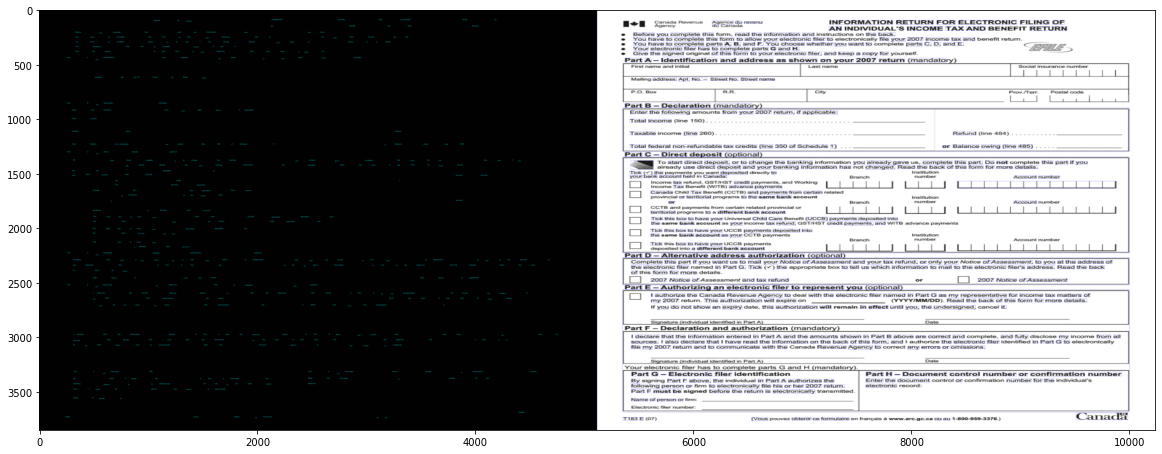

In [66]:
results = ocr_patch(img, crop = None, scale = 5, viz = True)
# results

In [75]:
filtered_words, filtered_conf = analyze_text(results)

No. of detected words: 813
No. of non-english words: 172
Dictionary words with their confidence are: 
           Words  Confidence Score
0    INFORMATION              0.01
1         RETURN              0.90
2            FOR              0.84
3     ELECTRONIC              0.82
4         FILING              0.93
..           ...               ...
516           or              0.95
517        tiler              0.55
518           en              0.88
519            8             -0.01
520       Canada              0.96

[521 rows x 2 columns]


There are 172 non-English words detected in the text out of 813 words (after filtering/excluding blanks and empty strings).

Ans 2.2)

In [77]:
import plotly.graph_objects as go

fig = go.Figure()

x = filtered_words
y = filtered_conf
fig.update_xaxes(title_text='Words')
fig.update_yaxes(title_text='Confidence Score')

# Add traces
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='markers'))

fig.show()

< placeholder to explain the types of words with high and low confidence scores >

From a quick scan, it can be seen that smaller words tend to have lower confidence scores.

Ans 2.3)

We change the `scale` parameter to see the changes in the confidence scores of the Eng dictionary words.

1024 770


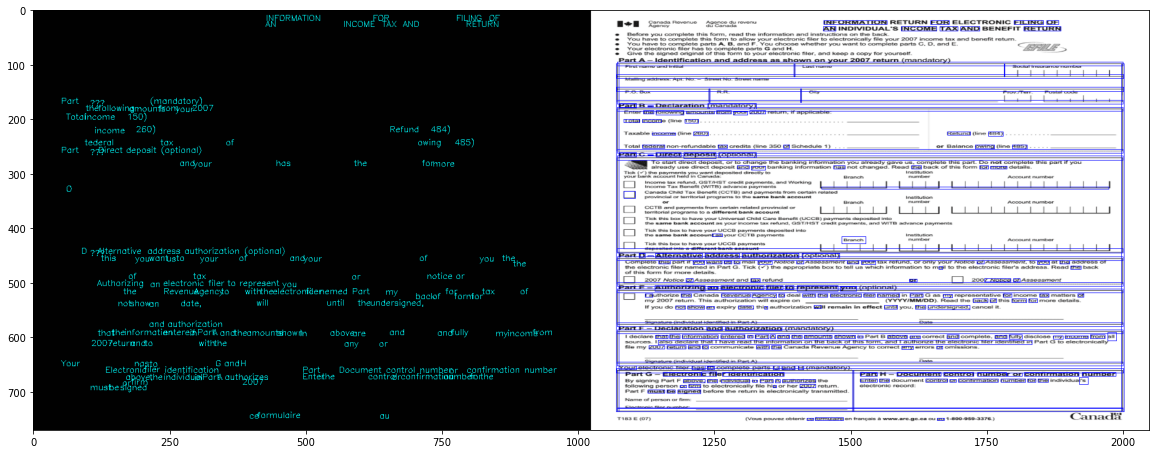

In [78]:
results = ocr_patch(img, crop = None, scale = 1, viz = True)
# results

In [79]:
words, scores = analyze_text(results)

No. of detected words: 725
No. of non-english words: 213
Dictionary words with their confidence are: 
              Words  Confidence Score
0            greens             -0.01
1       INFORMATION              0.34
2               FOR              0.09
3        ELECTRONIC              0.30
4            FILING              0.90
..              ...               ...
288          return             -0.01
289  electronically              0.95
290            1183             -0.01
291              on             -0.01
292          Canada              0.61

[293 rows x 2 columns]


The non-English words count increased to 213 from 172, meaning the captured text is less (as we saw in part 1) for `scale` = 1.

In [80]:
fig = go.Figure()

x = words
y = scores
fig.update_xaxes(title_text='Words')
fig.update_yaxes(title_text='Confidence Score')

# Add traces
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='markers'))

fig.show()

It is also interesting to notice that the confidence scores of Eng words  reduced with a lower value of `scale` = 1!

The confidence scores of Eng words are fairly high for higher `scale` (for ex. 5)

##### **Q3.a** Implement cropping in `ocr_patch` function below and try out a few random crops. Add the images to your report. [10]
*Hint:* You can create an array with several iterations of the `ocr_patch` parameters, e.g. `[[0, 0, 200, 100], [0, 0, 200, 200], [0, 0, 500, 500]]`. For each of these crop combinations, run the `ocr_patch` function.
##### **Q3.b** How does the quality of detection change in the crop, how do the confidences change? [10]

In [ ]:
bboxes = result_q1a["bbox"]

# Code here (approx. 2 lines)

### Part 2: Text Localization [55 + 15 available bonus]

You may have seen that the crops are more meaningful. This is because OCR performs better without a lot of background context. In fact, tesseract tries to do it using moslty classical CV techniques. We will now use deep learning to get better localization, and see how our OCR quality improves. Note that it takes about a minute for the models to download.

In [ ]:
import sys
sys.path.append("/content/unilm")

import cv2

from unilm.dit.object_detection.ditod import add_vit_config

import torch

from detectron2.config import CfgNode as CN
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor

# Step 1: instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("/content/unilm/dit/text_detection/configs/mask_rcnn_dit_base.yaml")

# Step 2: add model weights URL to config
cfg.MODEL.WEIGHTS = "https://layoutlm.blob.core.windows.net/dit/dit-fts/funsd_dit-b_mrcnn.pth"

# Step 3: set device
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device

# Step 4: define model
predictor = DefaultPredictor(cfg)

# Step 5: run inference
img_path = 'https://www.signnow.com/preview/14/715/14715322/large.png'
img = download_image(img_path)

md = MetadataCatalog.get(cfg.DATASETS.TEST[0])

if cfg.DATASETS.TEST[0]=='icdar2019_test':
    md.set(thing_classes=["table"])
else:
    md.set(thing_classes=["text","title","list","table","figure"])

output = predictor(img)["instances"]
v = Visualizer(img[:, :, ::-1],
                md,
                scale=1.0,
                instance_mode=ColorMode.SEGMENTATION)
result = v.draw_instance_predictions(output.to("cpu"))
result_image = result.get_image()[:, :, ::-1]

plt.figure(figsize=(15,15))
plt.imshow(result_image)
plt.show()

##### **Q4.a** Use the outputs from above to crop the image and run tesseract. Do we get better predictions now? How does the runtime change? What can you do to improve the predictions?  [10]

##### **Q4.b**  Comment on the speed/accuracy tradeoff. If we miss parts of the image, why do you think this is happening? Add relevant images along with your answer. [5]

*Note 1:* You can alternatively use the object detection model. This may help with the runtime consideration. 

*Hint:* You may need to remove some redundant detections above; how would you do that?

*Bonus:* Try a different model, by changing step 1 and 2. You may use paths from [here](https://github.com/microsoft/unilm/tree/master/dit/text_detection).

In [ ]:
bboxes = output.get("pred_boxes").tensor.cpu().numpy().astype(int)
scores = output.get("scores").cpu().numpy()

##### **Q5.a** Now let's see how handwritten text on this form changes our predicitons. Download the file from the img_path link above and fill it out with arbitary data (you can use a tablet or print it, fill it, and upload it). [10]
*Hint:* For each of the `bboxes` defined above, print and run `ocr_patch` with that crop.


*Bonus:* You can fill some parts  of the document in another language.




In [ ]:
# Code here (3 lines)

In [ ]:
# Note this may not work in Firefox so you may have to upload manually under 'files' on the left hand menu
from google.colab import files
uploaded = files.upload() 

##### **Q5.b** Run `ocr_patch`  on the whole image and comment on how the handwritten parts appear. Add the image into this report. [5]

In [ ]:
# Code here

##### **Q5.c** Run our localization model and see if we are able to localize the handwritten parts well. Add some images in the report. [10]

*Bonus 1:* If you filled the some parts of the form in another language, how does our approch work there? [10]

*Bonus 2:* How does a form filled out using a tablet vs. an image of a printed and scanned form perform? Which do you expect to perform better? [5]


##### **Q6** What are some potential sources of bias that may lead to bad predictions? What are some ways to alleviate them? [15]
*Hint: Comment on image quality, type of data used in the DiT paper, language of data vs. prediction.*